In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import randint

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", parse_dates=['DATE'])
df.columns = ['Date', 'Electricity']
df = df.sort_values('Date').set_index('Date').asfreq('MS')
df = df.dropna()
df.head()

,Electricity
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [12]:
def create_features(df, lags=12):
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['Electricity'].shift(lag)
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df.dropna()

df = create_features(df)
df['rolling_mean_7'] = df['Electricity'].rolling(window=7).mean()
df['day'] = df.index.day
df['quarter'] = df.index.quarter
df.head()

,Electricity,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,month,year,rolling_mean_7,day,quarter
Date,,,,,,,,,,,,,,,,,,
1993-01-01,87.9464,84.5159,73.4992,69.0286,72.3541,76.5374,77.5081,71.2078,67.1784,69.6441,74.5275,80.1643,85.2855,1,1993,NaN,1,1
1993-02-01,84.5561,87.9464,84.5159,73.4992,69.0286,72.3541,76.5374,77.5081,71.2078,67.1784,69.6441,74.5275,80.1643,2,1993,NaN,1,1
1993-03-01,79.4747,84.5561,87.9464,84.5159,73.4992,69.0286,72.3541,76.5374,77.5081,71.2078,67.1784,69.6441,74.5275,3,1993,NaN,1,1
1993-04-01,71.0578,79.4747,84.5561,87.9464,84.5159,73.4992,69.0286,72.3541,76.5374,77.5081,71.2078,67.1784,69.6441,4,1993,NaN,1,2
1993-05-01,67.6762,71.0578,79.4747,84.5561,87.9464,84.5159,73.4992,69.0286,72.3541,76.5374,77.5081,71.2078,67.1784,5,1993,NaN,1,2


In [13]:
test_size = 24
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

X_train, y_train = train.drop('Electricity', axis=1), train['Electricity']
X_test, y_test = test.drop('Electricity', axis=1), test['Electricity']

In [14]:
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': randint(2, 20)
}

In [15]:
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor(random_state=42)
search = RandomizedSearchCV(rf, param_dist, n_iter=50, cv=tscv, 
                           scoring='neg_mean_squared_error', n_jobs=-1)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025C9E03BF90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025CA0C43B90>},
                   scoring='neg_mean_squared_error')

In [16]:
best_rf = search.best_estimator_

test_preds = best_rf.predict(X_test)

In [17]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mae, rmse, mape

mae, rmse, mape = calculate_metrics(y_test, test_preds)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 3.73, RMSE: 5.09, MAPE: 3.51%


In [20]:
last_known_values = df.iloc[-1].drop('Electricity')

future_dates = pd.date_range(start=df.index[-1], periods=60, freq='MS')
future_data = pd.DataFrame(index=future_dates)

for col in X_train.columns:
    future_data[col] = last_known_values[col]

future_predictions = best_rf.predict(future_data)

future_data['Production_Predicted'] = future_predictions

In [23]:
last_known_values = df.iloc[-1].drop('Electricity')

future_dates = pd.date_range(start=df.index[-1], periods=30, freq='D')
future_data = pd.DataFrame(index=future_dates)

for col in X_train.columns:
    future_data[col] = last_known_values[col]

future_predictions = best_rf.predict(future_data)

future_data['Production_Predicted'] = future_predictions

In [25]:
future_predictions

array([117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673, 117.71722673, 117.71722673,
       117.71722673, 117.71722673])

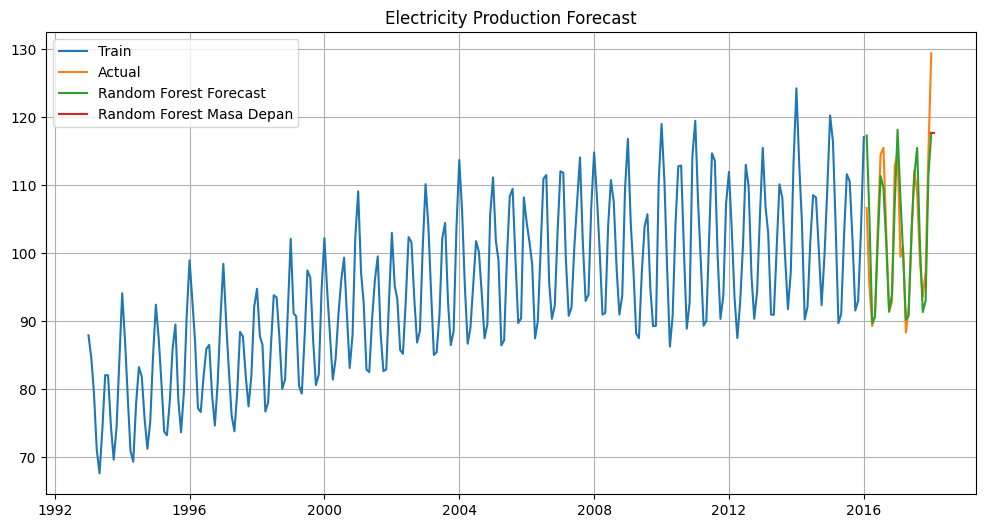

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Electricity'], label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, test_preds, label='Random Forest Forecast')
plt.plot(future_dates, future_predictions, label='Random Forest Masa Depan')
plt.title('Electricity Production Forecast')
plt.legend()
plt.grid(True)
plt.show()

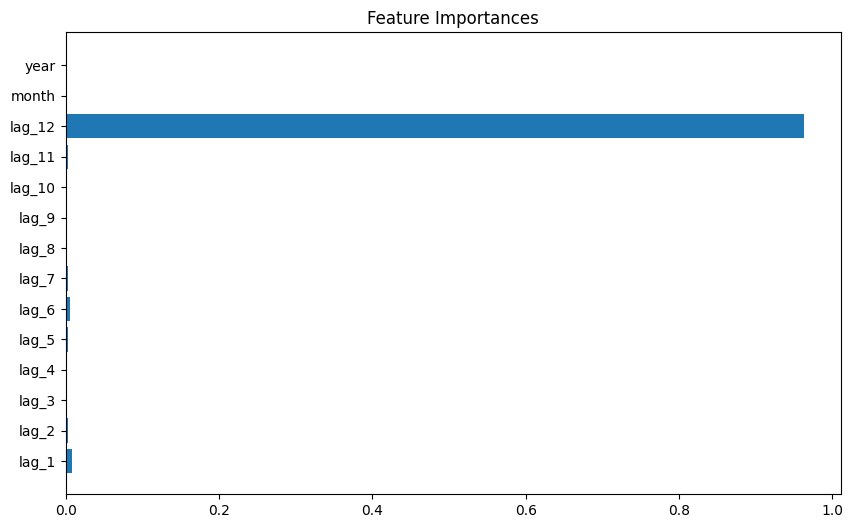

In [10]:
importances = best_rf.feature_importances_
features = X_train.columns
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.title('Feature Importances')
plt.show()